In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import cv2
import os

from keras.models import Sequential
from keras.layers import  Dropout, Flatten, Dense
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.font_manager as font_manager

import pickle

In [3]:
path = '/content/drive/MyDrive/License Plate Detection/Dataset'
testRatio = 0.2
valRatio = 0.2
imageDimentions = (32,32,3)

In [4]:
images = []
classNo = []
myList = os.listdir(path)
print("Total No of Classes Detected", len(myList))
noOfClasses = len(myList)

print("Importing Classes..........")
for x in range (0, noOfClasses):
    myPicList = os.listdir(path+"/"+str(x))
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(x)+"/"+y)
        if curImg is not None:
            curImg = cv2.resize(curImg, (imageDimentions[0], imageDimentions[1]))
            images.append(curImg)
            classNo.append(x)
    print(x, end= " ")
print(" ")

Total No of Classes Detected 19
Importing Classes..........
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18  


In [5]:
images = np.array(images)
classNo = np.array(classNo)

# print(images.shape)
# print(classNo.shape)

In [6]:
#### Spliting the data
x_train, x_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=valRatio)

print(x_train.shape)
print(x_test.shape)
print(x_validation.shape)

numOfSamples = []
for x in range(0, noOfClasses):
    #print(len(np.where(y_train==0)[0]))
    numOfSamples.append(len(np.where(y_train==x)[0]))
print(numOfSamples)

(8904, 32, 32, 3)
(2783, 32, 32, 3)
(2227, 32, 32, 3)
[261, 633, 637, 656, 615, 644, 648, 663, 649, 648, 187, 318, 320, 324, 271, 330, 304, 400, 396]


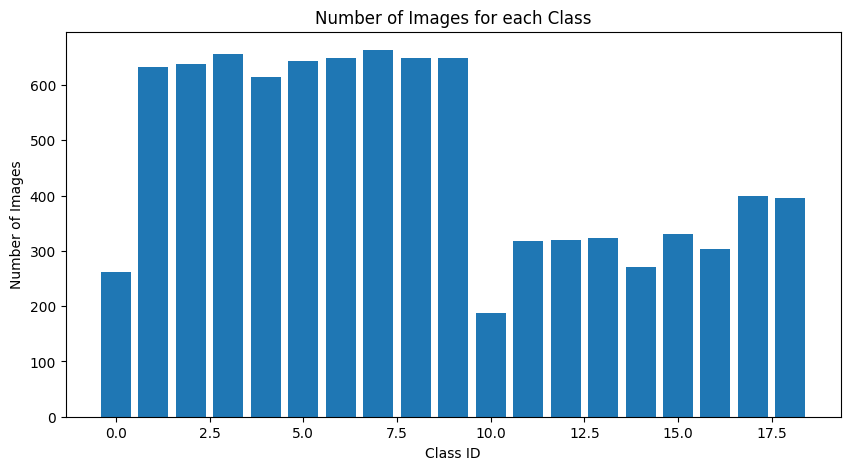

In [7]:
plt.figure(figsize=(10, 5))
plt.bar(range(0, noOfClasses), numOfSamples)
plt.title("Number of Images for each Class")
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.show()

In [8]:
#### Pre-processing
def preProcessing(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img/255
    return img

In [9]:
### Define Model
def create_CNN_model():
    model = Sequential()

    # add a convolutional layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=imageDimentions))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # add a convolutional layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # flatten the output from the convolutional layers
    model.add(Flatten())

    # add a dense layer with 128 units
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # add the final dense layer with the number of units equal to the number of classes
    model.add(Dense(noOfClasses, activation='softmax'))

    # compile the model using the Adam optimizer
    model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [10]:
model = create_CNN_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)          0

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
y_train = to_categorical(y_train, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)

In [12]:
# normalize the pixel values between 0 and 1
x_train = x_train/255
x_test = x_test/255
x_validation = x_validation/255

In [13]:
# create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(x_train)

dataGen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)
dataGen.fit(x_train)

In [14]:
len(x_train)

8904

In [15]:
# specify the batch size and number of epochs
batch_size = 32
epochs = 20

# fit the model to the data
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train)//batch_size,
                    epochs=epochs,
                    validation_data=(x_validation, y_validation),
                    shuffle=1)

Epoch 1/20
278/278 [==============================] - 21s 70ms/step - loss: 2.7665 - accuracy: 0.0792 - val_loss: 2.4570 - val_accuracy: 0.1289
Epoch 2/20
278/278 [==============================] - 20s 72ms/step - loss: 2.4254 - accuracy: 0.1293 - val_loss: 2.2106 - val_accuracy: 0.1711
Epoch 3/20
278/278 [==============================] - 22s 79ms/step - loss: 2.2564 - accuracy: 0.1502 - val_loss: 2.1575 - val_accuracy: 0.1675
Epoch 4/20
278/278 [==============================] - 20s 71ms/step - loss: 2.2015 - accuracy: 0.1601 - val_loss: 2.1277 - val_accuracy: 0.1702
Epoch 5/20
278/278 [==============================] - 22s 77ms/step - loss: 2.1575 - accuracy: 0.1681 - val_loss: 2.1037 - val_accuracy: 0.1751
Epoch 6/20
278/278 [==============================] - 20s 70ms/step - loss: 2.1412 - accuracy: 0.1737 - val_loss: 2.1112 - val_accuracy: 0.1733
Epoch 7/20
278/278 [==============================] - 20s 70ms/step - loss: 2.1277 - accuracy: 0.1690 - val_loss: 2.1014 - val_accuracy:

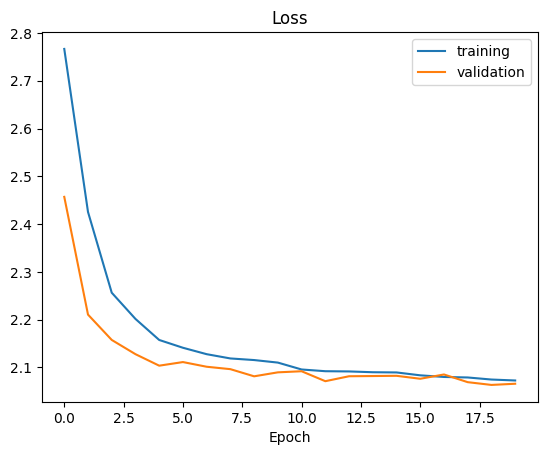

In [16]:
# Plotting training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

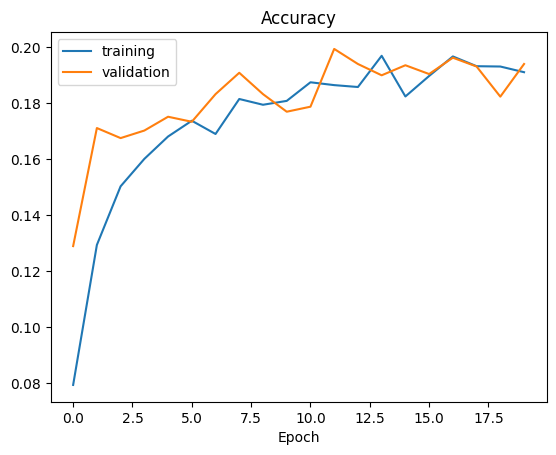

In [17]:
# Plotting training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [18]:
# evaluate the model on the test data
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_acc)

Test Loss:  2.0434231758117676
Test Accuracy:  0.19619116187095642


In [19]:
model.save('/content/drive/MyDrive/License Plate Detection/ocr_model.h5')

### **Testing**

In [116]:
!pip install easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [117]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import imutils

import easyocr
import openpyxl
from keras.models import load_model

In [118]:
from keras.saving.saving_api import load_model
model_path = '/content/drive/MyDrive/License Plate Detection/ocr_model.h5'
model = load_model(model_path)

In [119]:
#load the images

image= cv2.imread('/content/drive/MyDrive/License Plate Detection/InputImages/167.jpg')

# **Filtering and Edge detection**
OpenCV

In [120]:
#convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#apply bilateral filter
filter= cv2.bilateralFilter(gray, 11,17,17) 

In [121]:
#Converting color

# img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#apply edge detection
edge= cv2.Canny(filter, 30,200) 


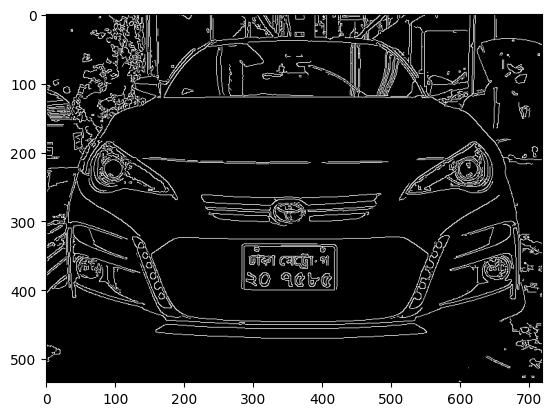

In [122]:
#Converting color

plt.imshow(cv2.cvtColor(edge, cv2.COLOR_BGR2RGB))

**Extracting Counters**

In [123]:
ext_count= cv2.findContours(edge.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contours= imutils.grab_contours(ext_count)
contours= sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [124]:
location= None

for contour in contours:
    apprx= cv2.approxPolyDP(
        contour, 10, True)
    
    if len(apprx)==4:
      location=apprx
      
      break

      

In [125]:
location

array([[[287, 337]],

       [[287, 399]],

       [[418, 400]],

       [[416, 337]]], dtype=int32)

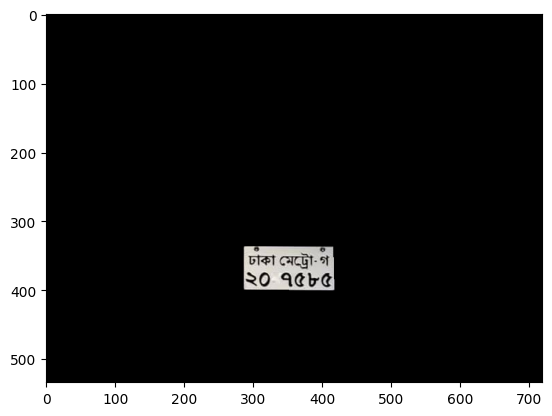

In [126]:
#masking
#extracting the plate

msk= np.zeros(gray.shape, np.uint8)

extracted_plate= cv2.drawContours(msk, [location], 0,255, -1)
extracted_plate= cv2.bitwise_and(image, image, mask=msk)

plt.imshow(cv2.cvtColor(extracted_plate, cv2.COLOR_BGR2RGB))

In [127]:
(x, y)= np.where(msk==255)

(x1, y1)= (np.min(x), np.min(y))
(x2, y2)= (np.max(x), np.max(y))

final_plate= gray[x1:x2+1, 
                  y1:y2+1]

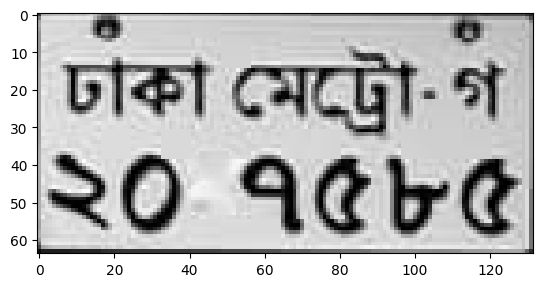

In [128]:
#final plate

plt.imshow(cv2.cvtColor(final_plate, cv2.COLOR_BGR2RGB))

In [129]:
read_char= easyocr.Reader(['bn'])  #bangla character reading with 'bn'

detected= read_char.readtext(final_plate)  #read from final extracted plate

In [130]:
#show the detected number

detected

[([[2, 6], [128, 6], [128, 36], [2, 36]], 'ঢাকা মেট্রো-গ', 0.4823770265898892),
 ([[0, 34], [132, 34], [132, 64], [0, 64]], '২০ 9৫৮৫', 0.8141945620167182)]

In [131]:
workbook = openpyxl.Workbook()
worksheet = workbook.active

In [132]:
# Location by Camera
worksheet.cell(row=1, column=1, value="IUBAT")

# iterate through the detected texts and add them to the subsequent rows
for i, text in enumerate(detected):
    worksheet.cell(row=i+2, column=1, value=text[1])

In [133]:
workbook.save('/content/drive/MyDrive/License Plate Detection/Output/license_plate_text.xlsx')